# PyTorch CIFAR-10 categorisation project

1. Explore the data
1. Create a baseline to judge results against
1. Implement a neural network
1. Implement improvements
1. Evaluate different parameters

## 1. Explore the data

In [1]:
import torch
from torch import cuda
from torch import nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torchvision.datasets import CIFAR10
from torchvision import transforms
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from pathlib import Path
import random

#set random seed for diff sources of randomness
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)
rng = np.random.default_rng(seed=0)

In [2]:
data_folder = r"../data"

transform = transforms.Compose([transforms.Resize(32),
                                transforms.ToTensor()])
CIFAR_data = CIFAR10(data_folder, train=True, transform=transform, download=True)

train_dataloader = DataLoader(CIFAR_data,
                          batch_size=4,
                          shuffle=True)

CIFAR_test_data = CIFAR10(data_folder, train=False, transform=transform)

test_dataloader = DataLoader(CIFAR_test_data,
                              batch_size=4,
                              shuffle=True)

Files already downloaded and verified


### Visualise data

The next cell creates train_X, train_y type data which we use to visualise the data and run our benchmark categorisation. The training of Neural Nets uses PyTorch dataloaders and not the objects created in cell below.

To help with initial data exploration, convert the entire data training set to 
tensors.

In [3]:
# to do that explicitly below. Images in DataLoader objects have pixel values
# in (0,1). The CIFAR_data.data has int values in (0,255) so have to convert
# to floats to take mean etc further down
train_imgs = torch.tensor(CIFAR_data.data).float()/255
train_y = torch.tensor(CIFAR_data.targets)
test_imgs = torch.tensor(CIFAR_test_data.data).float()/255
test_y = torch.tensor(CIFAR_test_data.targets)

classes = CIFAR_data.classes

# We need a map to get from index to class name.
# So need to reverse .class_to_idx dict:
labels_map = {}
for key, val in CIFAR_data.class_to_idx.items():
    labels_map[val] = key

Plot random sample of the data:

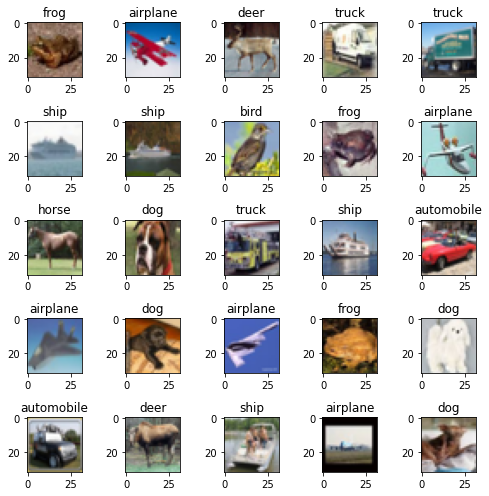

In [4]:
fig, axs = plt.subplots(5,5,figsize=(7,7))

for ax in axs.flatten():
    i = torch.randint(50000, (1,1)).item()
    ax.imshow(train_imgs[i])
    ax.set_title(labels_map[train_y[i].item()])
plt.tight_layout()

## Prepare data for benchmark categorisation

We create the training and validation data and labels.

The data is reshaped to a 4-dimensional tensor. dim 0 corresponds to list of images dim 1 is "depth" - so 3 layers for RGB; dim 2 and 3 are for the 32 pixels height and width of the images. 

We didvide pixel values by 255 so that PyTorch can work with floating point numbers in (0,1).

In [5]:
test_y.shape, test_imgs.shape, train_y.shape, train_imgs.shape

(torch.Size([10000]),
 torch.Size([10000, 32, 32, 3]),
 torch.Size([50000]),
 torch.Size([50000, 32, 32, 3]))

## Create a benchmark to judge neural net results against

Will an accuracy of above 10% imply that our neural net is doing better than chance and therefore doing a good job? Maybe.

To create a benchmark, we do a very simple prediction: we calculate the value of the "average" pixel for all the images in each category. Then for each image, we 

First create a benchmark to measure results of training neural net on.

We calculate the average RGB value for each pixel for each category. Then calculate the distance of an image form the average image for each category. Shortest distance is classified as that image. Can we do better than 10% accuracy??

In [6]:
avg_img = torch.zeros((10,32,32,3))
for i in np.arange(10):
    mask = train_y == i
    avg_img[i] = train_imgs[mask].mean(0)
    

Display our "average images". Kinda cool! The automobile and truck look like vehicles coming through the mist and the colours look different for different categories. There will be a lot of confusion between wild animals and cars/trucks for example, but the prediction based on distance from mean image should be quite good.

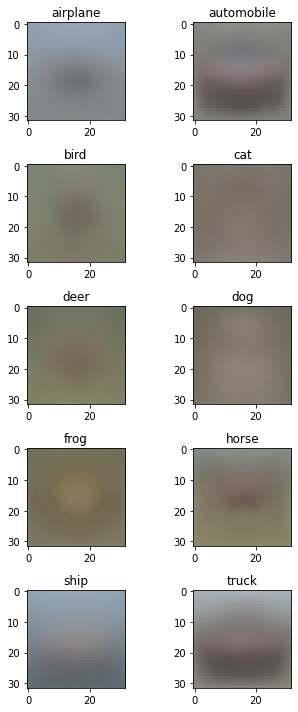

In [7]:
fig, axs = plt.subplots(5,2,figsize=(5,10))

for i, ax in enumerate(axs.flatten()):
    ax.imshow(avg_img[i])
    ax.set_title(labels_map[i])
plt.tight_layout()

Test our benchmark prediction. 28%!! Pretty good for just calculating an average. We now need our neural net to outperform 28% accuracy to be any good.

In [8]:
def cifar_distance(a,b): return ((a-b)**2).abs().mean((-1,-2,-3))
def predictions(a): return torch.argmin(a, dim=1)

preds = predictions(cifar_distance(test_imgs[:,None], avg_img[None]))
accuracy = (preds == test_y).sum()/test_imgs.shape[0]
accuracy

tensor(0.2774)

Just for curiousity, let's plot the confusion matrix. Some parts are as we expect from out crude method: it gets confused between deer and frogs (green backgrounds?) and birds and planes (sky?). 

Finally, there were 1000 of each category in the 10,000 test data set. However, our simple rule predicted either airplane or frog 4,500 times. So a lot of images look like the average frog or airplane!

(tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 tensor([2016,  657,  378,  211,  432, 1065, 2485,  622,  885, 1249]))

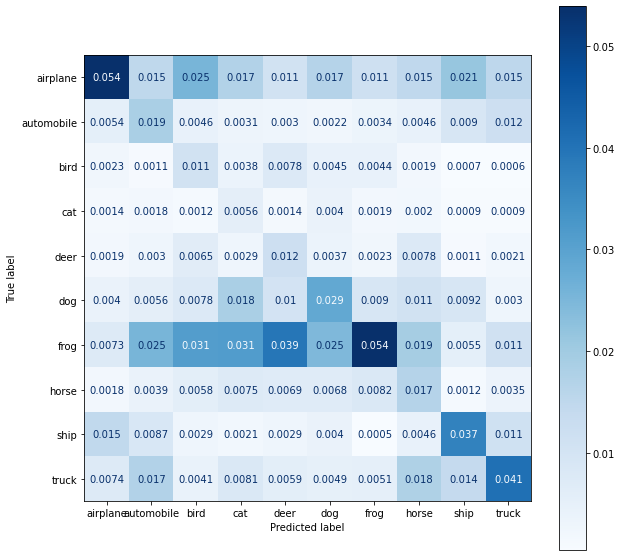

In [9]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
display(torch.unique(preds, return_counts=True))

cm = confusion_matrix(preds, test_y,
                      normalize='all')
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=classes
                             )

fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax, cmap='Blues')
ax.grid(False)

## 3. Implement a neural network

Create the initial neural network

In [10]:
device = torch.device('cuda:0' if cuda.is_available() else 'cpu')
device

device(type='cpu')

Prepare the data. To check code runs, I will do a tiny amount of training data.

We also flatten the image data to vectors so that we can feed into a basic NN.

In [11]:
num_epochs = 50
batch_size = 100
learning_rate = 0.005

# I wasn't going to copy Cactus_classification, but defining 'criterion'
# gives good flexibility
criterion = nn.CrossEntropyLoss()

#### Prepare data

The code below is almost an exact copy of cell 2, above. We've recreated to give us the flexibility to have a smaller training and test set whilst running on local machines. We also have target tranform below which one-hot-encodes the labels.

In [12]:
transform = transforms.Compose([transforms.ToTensor(), #transforms.Resize(32),
                                # transforms.Lambda(lambda x: torch.flatten(x))
                               ])
target_transforms = transforms.Lambda(lambda y: torch.zeros(10, dtype=torch.float)
                                     .scatter_(0, torch.tensor(y), value=1))

# Prepare 1000 sample training set
CIFAR_data_small = CIFAR10(data_folder, train=True, 
                           transform=transform,
                           target_transform=target_transforms,
                           download=False)
CIFAR_data_small.data = CIFAR_data_small.data[:]
CIFAR_data_small.targets = CIFAR_data_small.targets[:]

# Prepare 1000 sample test set (weird balance, but easy to test)
CIFAR_test_small = CIFAR10(data_folder, train=False, 
                           transform=transform,
                           target_transform=target_transforms,
                           download=False)
CIFAR_test_small.data = CIFAR_test_small.data[:]
CIFAR_test_small.targets = CIFAR_test_small.targets[:]

train_small_dl = DataLoader(CIFAR_test_small,
                          batch_size=batch_size,
                          shuffle=True)

test_small_dl = DataLoader(CIFAR_test_small,
                          batch_size=batch_size,
                          shuffle=True)

In [13]:
CIFAR_data_small.data.shape, type(CIFAR_data_small.data), CIFAR_test_small.data.shape

((50000, 32, 32, 3), numpy.ndarray, (10000, 32, 32, 3))

Check that we have one-hot encoded the labels data. Looks like we have!

In [14]:
train_features, train_labels = next(iter(test_small_dl))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
# img = train_features[0].permute(1,2,0)
label = train_labels[0]
# plt.imshow(img)
# plt.show()
print(f"Label: {label}")

Feature batch shape: torch.Size([100, 3, 32, 32])
Labels batch shape: torch.Size([100, 10])
Label: tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.])


In [15]:
# Define model

# models should subclass nn.Module. Docs here:
# https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        # This flattens the 3 x 32 x 32 image matrices to vectors
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            # nn.Flatten(),
            nn.Linear(3*32*32, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=3072, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [16]:
# print("Model structure: ", model, "\n\n")

# for name, param in model.named_parameters():
#     print(f"Layer: {name} | Size: {param.size()} | Values : {param[:2]} \n")

## Training the model

In [17]:
def train_val(model, train_small_dl=train_small_dl, test_small_dl=test_small_dl, num_epochs=num_epochs, learning_rate=learning_rate, visible=True):
    
    criterion = nn.CrossEntropyLoss()
    # keeping-track-of-losses 
    train_losses = []
    valid_losses = []
    # set optimiser here - it uses model parameters as input
    optimizer = torch.optim.SGD(model.parameters(),lr = learning_rate)

    for epoch in range(1, num_epochs + 1):
    # keep-track-of-training-and-validation-loss
        train_loss = 0.0
        valid_loss = 0.0
    
    # training-the-model
        model.train()
        for data, target in train_small_dl:
        # move-tensors-to-GPU / CPU
            data = data.to(device)
            target = target.to(device)
            target_i =torch.argmax(target, dim=1)
        # clear-the-gradients-of-all-optimized-variables
            optimizer.zero_grad()
        # forward-pass: compute-predicted-outputs-by-passing-inputs-to-the-model
            output = model(data)
        # calculate-the-batch-loss
            loss = criterion(output, target_i)
        # backward-pass: compute-gradient-of-the-loss-wrt-model-parameters
            loss.backward()
        # perform-a-single-optimization-step (parameter-update)
            optimizer.step()
        # update-training-loss
            train_loss += loss.item() * data.size(0)
        
    # validate-the-model
        model.eval()
        for data, target in test_small_dl:
        
            data = data.to(device)
            target = target.to(device)
            target_i =torch.argmax(target, dim=1)
            output = model(data)
        
            loss = criterion(output, target_i)
        
        # update-average-validation-loss 
            valid_loss += loss.item() * data.size(0)
    
    # calculate-average-losses
        train_loss = train_loss/len(train_small_dl.sampler)
        valid_loss = valid_loss/len(test_small_dl.sampler)
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        
    # print-training/validation-statistics 
        if visible:
            print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(epoch, train_loss, valid_loss))
    
    # plot-training/validation-statistics
    if visible:
        plt.plot(np.arange(1, num_epochs + 1), train_losses, label = "Training")
        plt.plot(np.arange(1, num_epochs + 1), valid_losses, label = "Validation")
        plt.title("Loss against Epoch")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.show()

#simplified version of above without using test data
def train(model, train_small_dl=train_small_dl, num_epochs=num_epochs, learning_rate=learning_rate, visible=True):
    
    criterion = nn.CrossEntropyLoss()
    # keeping-track-of-losses 
    train_losses = []

    # set optimiser here - it uses model parameters as input
    optimizer = torch.optim.SGD(model.parameters(),lr = learning_rate)

    for epoch in range(1, num_epochs + 1):
    # keep-track-of-training-and-validation-loss
        train_loss = 0.0

    
    # training-the-model
        model.train()
        for data, target in train_small_dl:
        # move-tensors-to-GPU / CPU
            data = data.to(device)
            target = target.to(device)
            target_i =torch.argmax(target, dim=1)
        # clear-the-gradients-of-all-optimized-variables
            optimizer.zero_grad()
        # forward-pass: compute-predicted-outputs-by-passing-inputs-to-the-model
            output = model(data)
        # calculate-the-batch-loss
            loss = criterion(output, target_i)
        # backward-pass: compute-gradient-of-the-loss-wrt-model-parameters
            loss.backward()
        # perform-a-single-optimization-step (parameter-update)
            optimizer.step()
        # update-training-loss
            train_loss += loss.item() * data.size(0)
        
    
    
    # calculate-average-losses
        train_loss = train_loss/len(train_small_dl.sampler)
      
        train_losses.append(train_loss)
        
    # print-training/validation-statistics 
        if visible:
            print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, train_loss))
    
    # plot-training/validation-statistics
    if visible:
        plt.plot(np.arange(1, num_epochs + 1), train_losses, label = "Training")

        plt.title("Loss against Epoch")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.show()


Epoch: 1 	Training Loss: 2.292141
Epoch: 2 	Training Loss: 2.270898
Epoch: 3 	Training Loss: 2.248361
Epoch: 4 	Training Loss: 2.220323
Epoch: 5 	Training Loss: 2.187291
Epoch: 6 	Training Loss: 2.150683
Epoch: 7 	Training Loss: 2.115475
Epoch: 8 	Training Loss: 2.084544
Epoch: 9 	Training Loss: 2.058008
Epoch: 10 	Training Loss: 2.035158
Epoch: 11 	Training Loss: 2.013968
Epoch: 12 	Training Loss: 1.995528
Epoch: 13 	Training Loss: 1.979173
Epoch: 14 	Training Loss: 1.963954
Epoch: 15 	Training Loss: 1.949295
Epoch: 16 	Training Loss: 1.936788
Epoch: 17 	Training Loss: 1.924375
Epoch: 18 	Training Loss: 1.913410
Epoch: 19 	Training Loss: 1.903048
Epoch: 20 	Training Loss: 1.893184
Epoch: 21 	Training Loss: 1.884527
Epoch: 22 	Training Loss: 1.875624
Epoch: 23 	Training Loss: 1.867741
Epoch: 24 	Training Loss: 1.859854
Epoch: 25 	Training Loss: 1.852817
Epoch: 26 	Training Loss: 1.845032
Epoch: 27 	Training Loss: 1.837563
Epoch: 28 	Training Loss: 1.830474
Epoch: 29 	Training Loss: 1.8

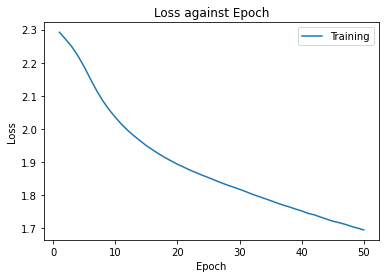

CPU times: user 5min 22s, sys: 5min 9s, total: 10min 31s
Wall time: 1min 33s


In [18]:
%%time
train(model)

## Test model on validation data

In [19]:
def test(model, test_small_dl=test_small_dl, visible=True):
    # test-the-model
    model.eval()  # it-disables-dropout
    with torch.no_grad():
        correct = 0
        total = 0
    # below calculates accuracy. Alex adapted from lab code and
    # it's not very pretty code. I transformed labels from one-
    # hot-encoded to integer labels and did the same for the 
    # softmax output in `predicted`
        for images, labels in test_small_dl:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            predicted = torch.argmax(outputs.data, dim=1)
            total += labels.size(0)
            labels = torch.argmax(labels, dim=1)
            correct += (predicted == labels).sum().item()
        
        accuracy = correct/total
        if visible:
            print('Test Accuracy of the model: {:.2f} %'.format(100 * accuracy))
    return accuracy

In [20]:
test(model)
# Save 
torch.save(model.state_dict(), 'model.ckpt')

Test Accuracy of the model: 40.83 %


# Improvement

The accuracy doesn't look good enough. So let's explore any room for improvement, potentially:
- CNN
- Standard Normalization
- Regularization by dropout/L2
- More data
- tuning parameters: batch size, learning rate, no of epochs, optimizer

## CNN

CNN (convolutional neural network, also called ConvNet) is a popular technique for image classification in machine learning. Unlike traditional fully connected neural network, CNN somehow retains the spatial relationship among features (i.e. pixels) of images. In the below, we will keep the previous neural network structure in the end, but add CNN layers in the beginning. As the image is small, we will start with 3x3 kernel size, 2x2 max pooling, with suitable padding generating same output shape. 

/Users/suenchihang/opt/anaconda3/envs/rosetta/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /tmp/pip-req-build-accccgfm/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch: 1 	Training Loss: 2.218806
Epoch: 2 	Training Loss: 2.020790
Epoch: 3 	Training Loss: 1.899828
Epoch: 4 	Training Loss: 1.782367
Epoch: 5 	Training Loss: 1.687354
Epoch: 6 	Training Loss: 1.576077
Epoch: 7 	Training Loss: 1.522438
Epoch: 8 	Training Loss: 1.490957
Epoch: 9 	Training Loss: 1.389077
Epoch: 10 	Training Loss: 1.333492
Epoch: 11 	Training Loss: 1.275216
Epoch: 12 	Training Loss: 1.216674
Epoch: 13 	Training Loss: 1.178682
Epoch: 14 	Training Loss: 1.116525
Epoch: 15 	Training Loss: 1.063403
Epoch: 16 	Training Loss: 0.993711
Epoch: 17 	Training Loss: 0.964043
Epoch: 18 	Training Loss: 0.887981
Epoch: 19 	Training Loss: 0.806179
Epoch: 20 	Training Loss: 0.727285
Epoch: 21 	Training Loss: 0.667674
Epoch: 22 	Training Loss: 0.582141
Epoch: 23 	Training Loss: 0.508579
Epoch: 24 	Training Loss: 0.417000
Epoch: 25 	Training Loss: 0.337137
Epoch: 26 	Training Loss: 0.341308
Epoch: 27 	Training Loss: 0.228503
Epoch: 28 	Training Loss: 0.167679
Epoch: 29 	Training Loss: 0.1

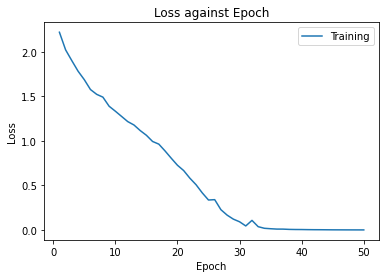

In [21]:
# Reference: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
            #https://cs231n.github.io/convolutional-networks/

#define model architecture
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 12, 3, padding='same') #2D convolution layer, 12 channels - kernels of 3x3, 
        self.pool = nn.MaxPool2d(2, 2)   #2D max pooling
        self.fc1 = nn.Linear(3072, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = CNN()


#train the model
train(net, learning_rate=0.1)

#save
torch.save(net.state_dict(), './cifar_net.pth')

In [22]:
test(net)

Test Accuracy of the model: 100.00 %


1.0

Epoch: 1 	Training Loss: 2.295233
Epoch: 2 	Training Loss: 2.178773
Epoch: 3 	Training Loss: 2.042125
Epoch: 4 	Training Loss: 1.951613
Epoch: 5 	Training Loss: 1.882380
Epoch: 6 	Training Loss: 1.753199
Epoch: 7 	Training Loss: 1.664415
Epoch: 8 	Training Loss: 1.564463
Epoch: 9 	Training Loss: 1.480579
Epoch: 10 	Training Loss: 1.416832
Epoch: 11 	Training Loss: 1.346570
Epoch: 12 	Training Loss: 1.285679
Epoch: 13 	Training Loss: 1.246553
Epoch: 14 	Training Loss: 1.173555
Epoch: 15 	Training Loss: 1.108543
Epoch: 16 	Training Loss: 1.044010
Epoch: 17 	Training Loss: 0.979557
Epoch: 18 	Training Loss: 0.904325
Epoch: 19 	Training Loss: 0.803832
Epoch: 20 	Training Loss: 0.740680
Epoch: 21 	Training Loss: 0.622727
Epoch: 22 	Training Loss: 0.553147
Epoch: 23 	Training Loss: 0.455032
Epoch: 24 	Training Loss: 0.347846
Epoch: 25 	Training Loss: 0.265307
Epoch: 26 	Training Loss: 0.188399
Epoch: 27 	Training Loss: 0.109948
Epoch: 28 	Training Loss: 0.054475
Epoch: 29 	Training Loss: 0.0

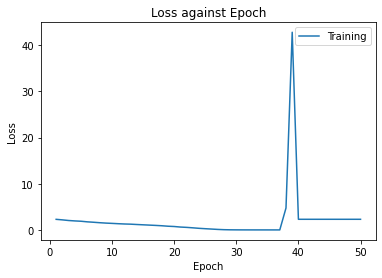

In [23]:
# Reference: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
            #https://cs231n.github.io/convolutional-networks/

#define model architecture
class CNN2(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 12, 3, padding='same') #2D convolution layer, 12 channels - kernels of 3x3, 
        self.pool = nn.MaxPool2d(2, 2)   #2D max pooling
        self.conv2 = nn.Conv2d(12, 48, 3, padding='same') ##2D convolution layer, 48 channels - kernels of 3x3, 
        self.fc1 = nn.Linear(3072, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net2 = CNN2()


#train the model
train(net2, learning_rate=0.1)

#save
torch.save(net2.state_dict(), './cifar_net2.pth')

In [24]:
test(net2)

Test Accuracy of the model: 10.00 %


0.1

## Next step after achieving accuracy 100.0% 
(running twice to double check results before fixed random seed is added). There should be little room for further improvement and no need for further tuning and testing parameters, except for experiment purpose. Please note that according to PyTorch, completely reproducible results are not guaranteed across PyTorch releases, individual commits, different platforms, or between CPU and GPU executions. (https://pytorch.org/docs/stable/notes/randomness.html).

Epoch: 1 	Training Loss: 2.193443
Epoch: 2 	Training Loss: 1.965114
Epoch: 3 	Training Loss: 1.821276
Epoch: 4 	Training Loss: 1.700837
Epoch: 5 	Training Loss: 1.625720
Epoch: 6 	Training Loss: 1.527272
Epoch: 7 	Training Loss: 1.449181
Epoch: 8 	Training Loss: 1.380224
Epoch: 9 	Training Loss: 1.312882
Epoch: 10 	Training Loss: 1.239942
Epoch: 11 	Training Loss: 1.193853
Epoch: 12 	Training Loss: 1.125005
Epoch: 13 	Training Loss: 1.062360
Epoch: 14 	Training Loss: 1.011217
Epoch: 15 	Training Loss: 0.943935
Epoch: 16 	Training Loss: 0.888156
Epoch: 17 	Training Loss: 0.813157
Epoch: 18 	Training Loss: 0.756422
Epoch: 19 	Training Loss: 0.679758
Epoch: 20 	Training Loss: 0.632122
Epoch: 21 	Training Loss: 0.531482
Epoch: 22 	Training Loss: 0.481415
Epoch: 23 	Training Loss: 0.441537
Epoch: 24 	Training Loss: 0.363010
Epoch: 25 	Training Loss: 0.306582
Epoch: 26 	Training Loss: 0.254216
Epoch: 27 	Training Loss: 0.227958
Epoch: 28 	Training Loss: 0.178932
Epoch: 29 	Training Loss: 0.1

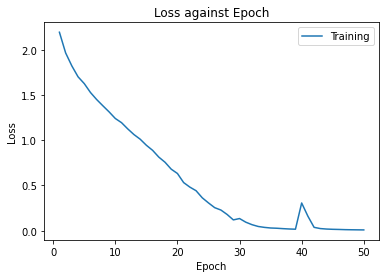

Test Accuracy of the model: 99.96 %


0.9996

In [25]:
#simplify by cutting one FC layer of CNN
class CNN1_2(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 12, 3, padding='same') #2D convolution layer, 12 channels - kernels of 3x3, 
        self.pool = nn.MaxPool2d(2, 2)   #2D max pooling
        self.fc1 = nn.Linear(3072, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

net1_2 = CNN1_2()


#train the model
train(net1_2, learning_rate=0.1)

#save
torch.save(net1_2.state_dict(), './cifar_net1_2.pth')

#testing vs test set
test(net1_2)

Epoch: 1 	Training Loss: 2.270247
Epoch: 2 	Training Loss: 2.220367
Epoch: 3 	Training Loss: 2.186664
Epoch: 4 	Training Loss: 2.166225
Epoch: 5 	Training Loss: 2.151466
Epoch: 6 	Training Loss: 2.137540
Epoch: 7 	Training Loss: 2.109459
Epoch: 8 	Training Loss: 2.079071
Epoch: 9 	Training Loss: 2.063783
Epoch: 10 	Training Loss: 2.040842
Epoch: 11 	Training Loss: 2.026176
Epoch: 12 	Training Loss: 2.011873
Epoch: 13 	Training Loss: 2.004066
Epoch: 14 	Training Loss: 1.985410
Epoch: 15 	Training Loss: 1.983451
Epoch: 16 	Training Loss: 1.964783
Epoch: 17 	Training Loss: 1.946991
Epoch: 18 	Training Loss: 1.895002
Epoch: 19 	Training Loss: 1.845879
Epoch: 20 	Training Loss: 1.828561
Epoch: 21 	Training Loss: 1.812226
Epoch: 22 	Training Loss: 1.799583
Epoch: 23 	Training Loss: 1.756313
Epoch: 24 	Training Loss: 1.745283
Epoch: 25 	Training Loss: 1.726161
Epoch: 26 	Training Loss: 1.708994
Epoch: 27 	Training Loss: 1.695734
Epoch: 28 	Training Loss: 1.680900
Epoch: 29 	Training Loss: 1.6

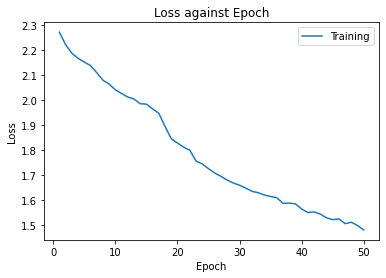

Test Accuracy of the model: 54.00 %


0.54

In [26]:
#simplify by cutting two FC layers of CNN
class CNN1_3(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 12, 3, padding='same') #2D convolution layer, 12 channels - kernels of 3x3, 
        self.pool = nn.MaxPool2d(2, 2)   #2D max pooling
        self.fc1 = nn.Linear(3072, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        return x

net1_3 = CNN1_3()


#train the model
train(net1_3, learning_rate=0.1)

#save
torch.save(net1_3.state_dict(), './cifar_net1_3.pth')

#testing vs test set
test(net1_3)

# Test and Evaluate Parameters

Since the data is balanced among different classes, we can simply use accuracy to evaluate models and ignore confusion matrix. As we have model attaining accuracy of 99.9% or 100.0% in test data, we don't need to worry about over-fitting and regularization and will choose the simplest structure for evaluating different parameters. i.e. the net1_2, which consists of 1 convolutional layer (12 channels, kernels size 3, with MaxPool(2,2) then RELU), followed by 1 hidden fully connected layer (512 nodes) and 1 output layer (10 classes). 

In [27]:
#create a general class of CNN with 1 conv layer, 1 hidden FC layer and 1 output layer
class CNN_variant(nn.Module):
    def __init__(self, k=12, n=512):
        super().__init__()
        self.conv1 = nn.Conv2d(3, k, 3, padding='same') #2D convolution layer, 12 channels - kernels of 3x3, 
        self.pool = nn.MaxPool2d(2, 2)   #2D max pooling
        self.fc1 = nn.Linear(256*k, n)
        self.fc2 = nn.Linear(n, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

Epoch: 1 	Training Loss: 2.219593
Epoch: 2 	Training Loss: 2.004346
Epoch: 3 	Training Loss: 1.878768
Epoch: 4 	Training Loss: 1.785026
Epoch: 5 	Training Loss: 1.723672
Epoch: 6 	Training Loss: 1.669815
Epoch: 7 	Training Loss: 1.624989
Epoch: 8 	Training Loss: 1.587044
Epoch: 9 	Training Loss: 1.537689
Epoch: 10 	Training Loss: 1.518291
Epoch: 11 	Training Loss: 1.466919
Epoch: 12 	Training Loss: 1.422208
Epoch: 13 	Training Loss: 1.385343
Epoch: 14 	Training Loss: 1.358132
Epoch: 15 	Training Loss: 1.335122
Epoch: 16 	Training Loss: 1.301676
Epoch: 17 	Training Loss: 1.282129
Epoch: 18 	Training Loss: 1.246208
Epoch: 19 	Training Loss: 1.216804
Epoch: 20 	Training Loss: 1.184904
Epoch: 21 	Training Loss: 1.156912
Epoch: 22 	Training Loss: 1.136018
Epoch: 23 	Training Loss: 1.092179
Epoch: 24 	Training Loss: 1.060667
Epoch: 25 	Training Loss: 1.033383
Epoch: 26 	Training Loss: 0.986108
Epoch: 27 	Training Loss: 0.959400
Epoch: 28 	Training Loss: 0.921942
Epoch: 29 	Training Loss: 0.8

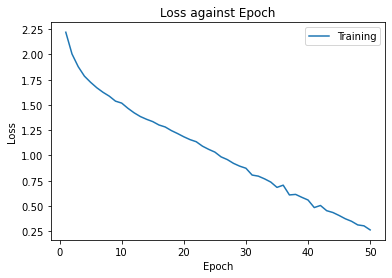

Test Accuracy of the model: 89.55 %
done for k=3; n=128
Epoch: 1 	Training Loss: 2.221657
Epoch: 2 	Training Loss: 2.015321
Epoch: 3 	Training Loss: 1.878592
Epoch: 4 	Training Loss: 1.759641
Epoch: 5 	Training Loss: 1.686819
Epoch: 6 	Training Loss: 1.615681
Epoch: 7 	Training Loss: 1.548888
Epoch: 8 	Training Loss: 1.493957
Epoch: 9 	Training Loss: 1.454646
Epoch: 10 	Training Loss: 1.413030
Epoch: 11 	Training Loss: 1.358903
Epoch: 12 	Training Loss: 1.328535
Epoch: 13 	Training Loss: 1.286260
Epoch: 14 	Training Loss: 1.249513
Epoch: 15 	Training Loss: 1.210880
Epoch: 16 	Training Loss: 1.160739
Epoch: 17 	Training Loss: 1.119236
Epoch: 18 	Training Loss: 1.077060
Epoch: 19 	Training Loss: 1.031441
Epoch: 20 	Training Loss: 0.988983
Epoch: 21 	Training Loss: 0.939079
Epoch: 22 	Training Loss: 0.922217
Epoch: 23 	Training Loss: 0.877658
Epoch: 24 	Training Loss: 0.815819
Epoch: 25 	Training Loss: 0.790094
Epoch: 26 	Training Loss: 0.709422
Epoch: 27 	Training Loss: 0.664221
Epoch: 2

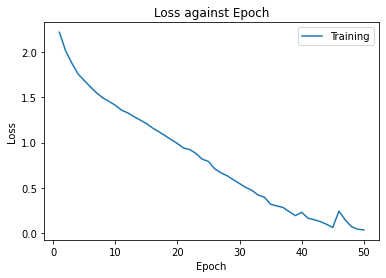

Test Accuracy of the model: 99.66 %
done for k=3; n=256
Epoch: 1 	Training Loss: 2.207205
Epoch: 2 	Training Loss: 2.059212
Epoch: 3 	Training Loss: 1.934217
Epoch: 4 	Training Loss: 1.840311
Epoch: 5 	Training Loss: 1.761638
Epoch: 6 	Training Loss: 1.686617
Epoch: 7 	Training Loss: 1.650614
Epoch: 8 	Training Loss: 1.600755
Epoch: 9 	Training Loss: 1.569417
Epoch: 10 	Training Loss: 1.540781
Epoch: 11 	Training Loss: 1.494733
Epoch: 12 	Training Loss: 1.464869
Epoch: 13 	Training Loss: 1.417231
Epoch: 14 	Training Loss: 1.392143
Epoch: 15 	Training Loss: 1.351006
Epoch: 16 	Training Loss: 1.312416
Epoch: 17 	Training Loss: 1.260666
Epoch: 18 	Training Loss: 1.220889
Epoch: 19 	Training Loss: 1.164962
Epoch: 20 	Training Loss: 1.109563
Epoch: 21 	Training Loss: 1.077021
Epoch: 22 	Training Loss: 1.017437
Epoch: 23 	Training Loss: 0.966491
Epoch: 24 	Training Loss: 0.910329
Epoch: 25 	Training Loss: 0.850504
Epoch: 26 	Training Loss: 0.806484
Epoch: 27 	Training Loss: 0.738242
Epoch: 2

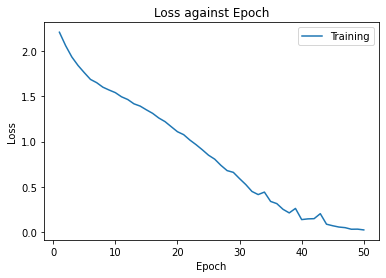

Test Accuracy of the model: 99.76 %
done for k=3; n=512
Epoch: 1 	Training Loss: 2.259936
Epoch: 2 	Training Loss: 2.068219
Epoch: 3 	Training Loss: 1.950959
Epoch: 4 	Training Loss: 1.864762
Epoch: 5 	Training Loss: 1.779349
Epoch: 6 	Training Loss: 1.726163
Epoch: 7 	Training Loss: 1.666454
Epoch: 8 	Training Loss: 1.614517
Epoch: 9 	Training Loss: 1.568686
Epoch: 10 	Training Loss: 1.526977
Epoch: 11 	Training Loss: 1.479983
Epoch: 12 	Training Loss: 1.433654
Epoch: 13 	Training Loss: 1.411937
Epoch: 14 	Training Loss: 1.362302
Epoch: 15 	Training Loss: 1.320939
Epoch: 16 	Training Loss: 1.281047
Epoch: 17 	Training Loss: 1.223588
Epoch: 18 	Training Loss: 1.188585
Epoch: 19 	Training Loss: 1.139794
Epoch: 20 	Training Loss: 1.083552
Epoch: 21 	Training Loss: 1.039185
Epoch: 22 	Training Loss: 0.991421
Epoch: 23 	Training Loss: 0.935047
Epoch: 24 	Training Loss: 0.880050
Epoch: 25 	Training Loss: 0.813309
Epoch: 26 	Training Loss: 0.775942
Epoch: 27 	Training Loss: 0.698496
Epoch: 2

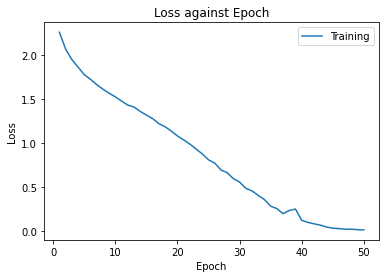

Test Accuracy of the model: 99.94 %
done for k=3; n=1024
Epoch: 1 	Training Loss: 2.238525
Epoch: 2 	Training Loss: 2.032796
Epoch: 3 	Training Loss: 1.931955
Epoch: 4 	Training Loss: 1.871164
Epoch: 5 	Training Loss: 1.814837
Epoch: 6 	Training Loss: 1.780258
Epoch: 7 	Training Loss: 1.740767
Epoch: 8 	Training Loss: 1.708961
Epoch: 9 	Training Loss: 1.691649
Epoch: 10 	Training Loss: 1.657408
Epoch: 11 	Training Loss: 1.643958
Epoch: 12 	Training Loss: 1.611704
Epoch: 13 	Training Loss: 1.590965
Epoch: 14 	Training Loss: 1.560871
Epoch: 15 	Training Loss: 1.539447
Epoch: 16 	Training Loss: 1.533088
Epoch: 17 	Training Loss: 1.502279
Epoch: 18 	Training Loss: 1.477557
Epoch: 19 	Training Loss: 1.461166
Epoch: 20 	Training Loss: 1.434678
Epoch: 21 	Training Loss: 1.416697
Epoch: 22 	Training Loss: 1.372302
Epoch: 23 	Training Loss: 1.342706
Epoch: 24 	Training Loss: 1.315041
Epoch: 25 	Training Loss: 1.280930
Epoch: 26 	Training Loss: 1.257419
Epoch: 27 	Training Loss: 1.232435
Epoch: 

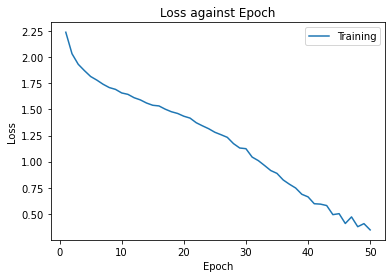

Test Accuracy of the model: 92.73 %
done for k=3; n=2048
Epoch: 1 	Training Loss: 2.228279
Epoch: 2 	Training Loss: 2.035329
Epoch: 3 	Training Loss: 1.886576
Epoch: 4 	Training Loss: 1.795316
Epoch: 5 	Training Loss: 1.726415
Epoch: 6 	Training Loss: 1.672464
Epoch: 7 	Training Loss: 1.614482
Epoch: 8 	Training Loss: 1.543015
Epoch: 9 	Training Loss: 1.506952
Epoch: 10 	Training Loss: 1.463357
Epoch: 11 	Training Loss: 1.404165
Epoch: 12 	Training Loss: 1.364631
Epoch: 13 	Training Loss: 1.336968
Epoch: 14 	Training Loss: 1.295927
Epoch: 15 	Training Loss: 1.250989
Epoch: 16 	Training Loss: 1.205669
Epoch: 17 	Training Loss: 1.173597
Epoch: 18 	Training Loss: 1.123396
Epoch: 19 	Training Loss: 1.094418
Epoch: 20 	Training Loss: 1.057872
Epoch: 21 	Training Loss: 1.016042
Epoch: 22 	Training Loss: 0.958185
Epoch: 23 	Training Loss: 0.934949
Epoch: 24 	Training Loss: 0.898743
Epoch: 25 	Training Loss: 0.857619
Epoch: 26 	Training Loss: 0.809870
Epoch: 27 	Training Loss: 0.767291
Epoch: 

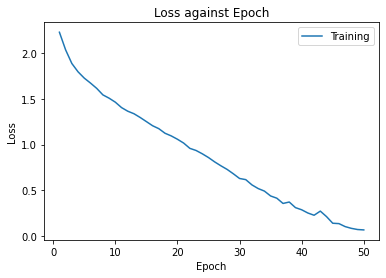

Test Accuracy of the model: 99.44 %
done for k=6; n=128
Epoch: 1 	Training Loss: 2.209950
Epoch: 2 	Training Loss: 2.000670
Epoch: 3 	Training Loss: 1.853661
Epoch: 4 	Training Loss: 1.762267
Epoch: 5 	Training Loss: 1.659002
Epoch: 6 	Training Loss: 1.580977
Epoch: 7 	Training Loss: 1.530092
Epoch: 8 	Training Loss: 1.458614
Epoch: 9 	Training Loss: 1.417810
Epoch: 10 	Training Loss: 1.361941
Epoch: 11 	Training Loss: 1.306119
Epoch: 12 	Training Loss: 1.267420
Epoch: 13 	Training Loss: 1.213165
Epoch: 14 	Training Loss: 1.167803
Epoch: 15 	Training Loss: 1.120745
Epoch: 16 	Training Loss: 1.059875
Epoch: 17 	Training Loss: 1.031846
Epoch: 18 	Training Loss: 0.970686
Epoch: 19 	Training Loss: 0.917381
Epoch: 20 	Training Loss: 0.851003
Epoch: 21 	Training Loss: 0.802011
Epoch: 22 	Training Loss: 0.753719
Epoch: 23 	Training Loss: 0.680974
Epoch: 24 	Training Loss: 0.620146
Epoch: 25 	Training Loss: 0.560389
Epoch: 26 	Training Loss: 0.521610
Epoch: 27 	Training Loss: 0.461928
Epoch: 2

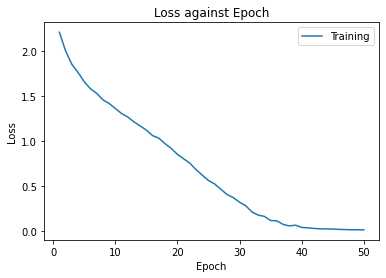

Test Accuracy of the model: 99.96 %
done for k=6; n=256
Epoch: 1 	Training Loss: 2.163749
Epoch: 2 	Training Loss: 1.972466
Epoch: 3 	Training Loss: 1.840172
Epoch: 4 	Training Loss: 1.772542
Epoch: 5 	Training Loss: 1.691629
Epoch: 6 	Training Loss: 1.616735
Epoch: 7 	Training Loss: 1.575967
Epoch: 8 	Training Loss: 1.507759
Epoch: 9 	Training Loss: 1.458136
Epoch: 10 	Training Loss: 1.391157
Epoch: 11 	Training Loss: 1.332114
Epoch: 12 	Training Loss: 1.286991
Epoch: 13 	Training Loss: 1.232630
Epoch: 14 	Training Loss: 1.174366
Epoch: 15 	Training Loss: 1.141544
Epoch: 16 	Training Loss: 1.098289
Epoch: 17 	Training Loss: 1.037075
Epoch: 18 	Training Loss: 0.982552
Epoch: 19 	Training Loss: 0.939117
Epoch: 20 	Training Loss: 0.876304
Epoch: 21 	Training Loss: 0.819298
Epoch: 22 	Training Loss: 0.785275
Epoch: 23 	Training Loss: 0.715527
Epoch: 24 	Training Loss: 0.670548
Epoch: 25 	Training Loss: 0.616974
Epoch: 26 	Training Loss: 0.564283
Epoch: 27 	Training Loss: 0.518386
Epoch: 2

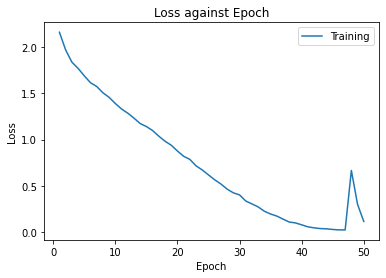

Test Accuracy of the model: 99.47 %
done for k=6; n=512
Epoch: 1 	Training Loss: 2.169407
Epoch: 2 	Training Loss: 1.940627
Epoch: 3 	Training Loss: 1.810957
Epoch: 4 	Training Loss: 1.716601
Epoch: 5 	Training Loss: 1.632530
Epoch: 6 	Training Loss: 1.571684
Epoch: 7 	Training Loss: 1.510641
Epoch: 8 	Training Loss: 1.436764
Epoch: 9 	Training Loss: 1.400980
Epoch: 10 	Training Loss: 1.349226
Epoch: 11 	Training Loss: 1.292077
Epoch: 12 	Training Loss: 1.246087
Epoch: 13 	Training Loss: 1.197512
Epoch: 14 	Training Loss: 1.146770
Epoch: 15 	Training Loss: 1.077507
Epoch: 16 	Training Loss: 1.032539
Epoch: 17 	Training Loss: 0.982671
Epoch: 18 	Training Loss: 0.920536
Epoch: 19 	Training Loss: 0.854398
Epoch: 20 	Training Loss: 0.802806
Epoch: 21 	Training Loss: 0.743350
Epoch: 22 	Training Loss: 0.677289
Epoch: 23 	Training Loss: 0.621834
Epoch: 24 	Training Loss: 0.546831
Epoch: 25 	Training Loss: 0.507356
Epoch: 26 	Training Loss: 0.443859
Epoch: 27 	Training Loss: 0.379711
Epoch: 2

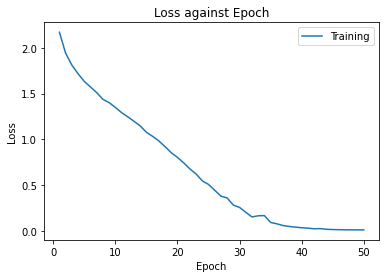

Test Accuracy of the model: 99.94 %
done for k=6; n=1024
Epoch: 1 	Training Loss: 2.164442
Epoch: 2 	Training Loss: 1.949735
Epoch: 3 	Training Loss: 1.784176
Epoch: 4 	Training Loss: 1.675432
Epoch: 5 	Training Loss: 1.582058
Epoch: 6 	Training Loss: 1.521708
Epoch: 7 	Training Loss: 1.446542
Epoch: 8 	Training Loss: 1.378892
Epoch: 9 	Training Loss: 1.329962
Epoch: 10 	Training Loss: 1.269786
Epoch: 11 	Training Loss: 1.211672
Epoch: 12 	Training Loss: 1.147278
Epoch: 13 	Training Loss: 1.087643
Epoch: 14 	Training Loss: 1.032782
Epoch: 15 	Training Loss: 0.961436
Epoch: 16 	Training Loss: 0.908272
Epoch: 17 	Training Loss: 0.812672
Epoch: 18 	Training Loss: 0.741132
Epoch: 19 	Training Loss: 0.682239
Epoch: 20 	Training Loss: 0.598915
Epoch: 21 	Training Loss: 0.540176
Epoch: 22 	Training Loss: 0.479325
Epoch: 23 	Training Loss: 0.423359
Epoch: 24 	Training Loss: 0.369299
Epoch: 25 	Training Loss: 0.292685
Epoch: 26 	Training Loss: 0.249615
Epoch: 27 	Training Loss: 0.172543
Epoch: 

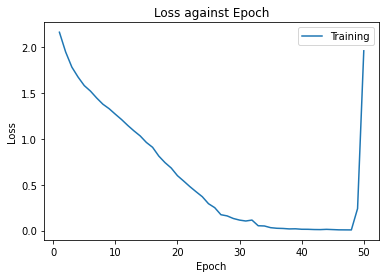

Test Accuracy of the model: 49.36 %
done for k=6; n=2048
Epoch: 1 	Training Loss: 2.193136
Epoch: 2 	Training Loss: 1.991392
Epoch: 3 	Training Loss: 1.839530
Epoch: 4 	Training Loss: 1.720400
Epoch: 5 	Training Loss: 1.644710
Epoch: 6 	Training Loss: 1.565836
Epoch: 7 	Training Loss: 1.492091
Epoch: 8 	Training Loss: 1.416022
Epoch: 9 	Training Loss: 1.348703
Epoch: 10 	Training Loss: 1.296227
Epoch: 11 	Training Loss: 1.210980
Epoch: 12 	Training Loss: 1.157463
Epoch: 13 	Training Loss: 1.125075
Epoch: 14 	Training Loss: 1.049454
Epoch: 15 	Training Loss: 1.005095
Epoch: 16 	Training Loss: 0.946940
Epoch: 17 	Training Loss: 0.892632
Epoch: 18 	Training Loss: 0.830302
Epoch: 19 	Training Loss: 0.779088
Epoch: 20 	Training Loss: 0.724502
Epoch: 21 	Training Loss: 0.661110
Epoch: 22 	Training Loss: 0.604484
Epoch: 23 	Training Loss: 0.546019
Epoch: 24 	Training Loss: 0.495197
Epoch: 25 	Training Loss: 0.451835
Epoch: 26 	Training Loss: 0.380365
Epoch: 27 	Training Loss: 0.349414
Epoch: 

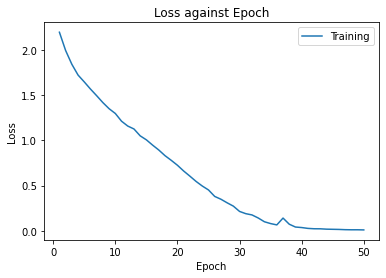

Test Accuracy of the model: 99.99 %
done for k=12; n=128
Epoch: 1 	Training Loss: 2.192223
Epoch: 2 	Training Loss: 2.000459
Epoch: 3 	Training Loss: 1.858971
Epoch: 4 	Training Loss: 1.763457
Epoch: 5 	Training Loss: 1.690460
Epoch: 6 	Training Loss: 1.606919
Epoch: 7 	Training Loss: 1.520854
Epoch: 8 	Training Loss: 1.462769
Epoch: 9 	Training Loss: 1.394299
Epoch: 10 	Training Loss: 1.325029
Epoch: 11 	Training Loss: 1.281520
Epoch: 12 	Training Loss: 1.229560
Epoch: 13 	Training Loss: 1.178833
Epoch: 14 	Training Loss: 1.126986
Epoch: 15 	Training Loss: 1.066846
Epoch: 16 	Training Loss: 1.033495
Epoch: 17 	Training Loss: 0.984024
Epoch: 18 	Training Loss: 0.922385
Epoch: 19 	Training Loss: 0.869588
Epoch: 20 	Training Loss: 0.811009
Epoch: 21 	Training Loss: 0.753024
Epoch: 22 	Training Loss: 0.707032
Epoch: 23 	Training Loss: 0.632078
Epoch: 24 	Training Loss: 0.577551
Epoch: 25 	Training Loss: 0.534633
Epoch: 26 	Training Loss: 0.472537
Epoch: 27 	Training Loss: 0.431892
Epoch: 

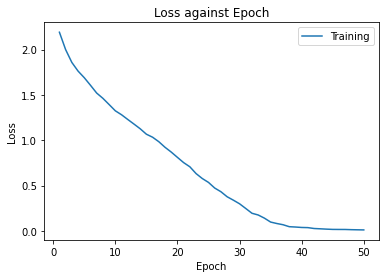

Test Accuracy of the model: 100.00 %
done for k=12; n=256
Epoch: 1 	Training Loss: 2.203805
Epoch: 2 	Training Loss: 1.973455
Epoch: 3 	Training Loss: 1.834997
Epoch: 4 	Training Loss: 1.691484
Epoch: 5 	Training Loss: 1.596902
Epoch: 6 	Training Loss: 1.504754
Epoch: 7 	Training Loss: 1.441276
Epoch: 8 	Training Loss: 1.368533
Epoch: 9 	Training Loss: 1.286203
Epoch: 10 	Training Loss: 1.229062
Epoch: 11 	Training Loss: 1.144864
Epoch: 12 	Training Loss: 1.087897
Epoch: 13 	Training Loss: 1.017052
Epoch: 14 	Training Loss: 0.939889
Epoch: 15 	Training Loss: 0.890911
Epoch: 16 	Training Loss: 0.816585
Epoch: 17 	Training Loss: 0.744572
Epoch: 18 	Training Loss: 0.672203
Epoch: 19 	Training Loss: 0.599710
Epoch: 20 	Training Loss: 0.553439
Epoch: 21 	Training Loss: 0.463626
Epoch: 22 	Training Loss: 0.419554
Epoch: 23 	Training Loss: 0.352084
Epoch: 24 	Training Loss: 0.289922
Epoch: 25 	Training Loss: 0.224788
Epoch: 26 	Training Loss: 0.187146
Epoch: 27 	Training Loss: 0.181803
Epoch:

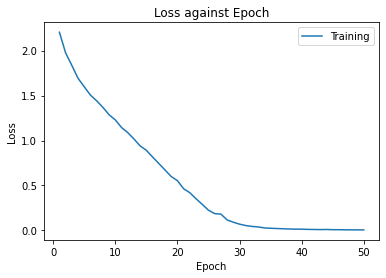

Test Accuracy of the model: 99.99 %
done for k=12; n=512
Epoch: 1 	Training Loss: 2.187028
Epoch: 2 	Training Loss: 1.964290
Epoch: 3 	Training Loss: 1.814687
Epoch: 4 	Training Loss: 1.696055
Epoch: 5 	Training Loss: 1.602084
Epoch: 6 	Training Loss: 1.534916
Epoch: 7 	Training Loss: 1.445818
Epoch: 8 	Training Loss: 1.391597
Epoch: 9 	Training Loss: 1.300869
Epoch: 10 	Training Loss: 1.226645
Epoch: 11 	Training Loss: 1.174572
Epoch: 12 	Training Loss: 1.101303
Epoch: 13 	Training Loss: 1.033964
Epoch: 14 	Training Loss: 0.956194
Epoch: 15 	Training Loss: 0.898750
Epoch: 16 	Training Loss: 0.835219
Epoch: 17 	Training Loss: 0.757990
Epoch: 18 	Training Loss: 0.705375
Epoch: 19 	Training Loss: 0.597878
Epoch: 20 	Training Loss: 0.555262
Epoch: 21 	Training Loss: 0.487977
Epoch: 22 	Training Loss: 0.413236
Epoch: 23 	Training Loss: 0.362947
Epoch: 24 	Training Loss: 0.311399
Epoch: 25 	Training Loss: 0.297510
Epoch: 26 	Training Loss: 0.217059
Epoch: 27 	Training Loss: 0.161432
Epoch: 

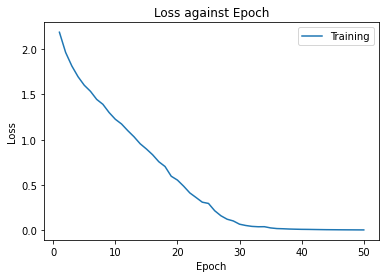

Test Accuracy of the model: 100.00 %
done for k=12; n=1024
Epoch: 1 	Training Loss: 2.144724
Epoch: 2 	Training Loss: 1.936056
Epoch: 3 	Training Loss: 1.776719
Epoch: 4 	Training Loss: 1.670368
Epoch: 5 	Training Loss: 1.562977
Epoch: 6 	Training Loss: 1.462502
Epoch: 7 	Training Loss: 1.380461
Epoch: 8 	Training Loss: 1.305763
Epoch: 9 	Training Loss: 1.239166
Epoch: 10 	Training Loss: 1.162308
Epoch: 11 	Training Loss: 1.083454
Epoch: 12 	Training Loss: 1.022557
Epoch: 13 	Training Loss: 0.948807
Epoch: 14 	Training Loss: 0.872019
Epoch: 15 	Training Loss: 0.794171
Epoch: 16 	Training Loss: 0.741393
Epoch: 17 	Training Loss: 0.647659
Epoch: 18 	Training Loss: 0.603362
Epoch: 19 	Training Loss: 0.511034
Epoch: 20 	Training Loss: 0.435664
Epoch: 21 	Training Loss: 0.379682
Epoch: 22 	Training Loss: 0.304300
Epoch: 23 	Training Loss: 0.252391
Epoch: 24 	Training Loss: 0.201000
Epoch: 25 	Training Loss: 0.303310
Epoch: 26 	Training Loss: 0.201238
Epoch: 27 	Training Loss: 0.125509
Epoch

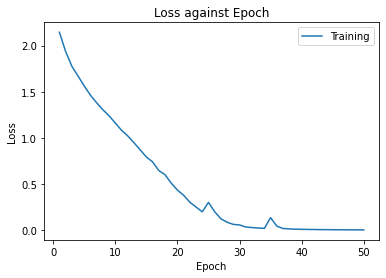

Test Accuracy of the model: 100.00 %
done for k=12; n=2048
Epoch: 1 	Training Loss: 2.205106
Epoch: 2 	Training Loss: 2.001762
Epoch: 3 	Training Loss: 1.860140
Epoch: 4 	Training Loss: 1.743494
Epoch: 5 	Training Loss: 1.633656
Epoch: 6 	Training Loss: 1.553600
Epoch: 7 	Training Loss: 1.456682
Epoch: 8 	Training Loss: 1.386216
Epoch: 9 	Training Loss: 1.309508
Epoch: 10 	Training Loss: 1.239323
Epoch: 11 	Training Loss: 1.206042
Epoch: 12 	Training Loss: 1.122049
Epoch: 13 	Training Loss: 1.071510
Epoch: 14 	Training Loss: 1.000281
Epoch: 15 	Training Loss: 0.966564
Epoch: 16 	Training Loss: 0.896060
Epoch: 17 	Training Loss: 0.855675
Epoch: 18 	Training Loss: 0.777624
Epoch: 19 	Training Loss: 0.735157
Epoch: 20 	Training Loss: 0.687286
Epoch: 21 	Training Loss: 0.613991
Epoch: 22 	Training Loss: 0.558714
Epoch: 23 	Training Loss: 0.527618
Epoch: 24 	Training Loss: 0.455139
Epoch: 25 	Training Loss: 0.419655
Epoch: 26 	Training Loss: 0.346815
Epoch: 27 	Training Loss: 0.303197
Epoch

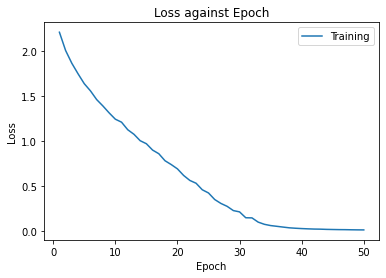

Test Accuracy of the model: 99.99 %
done for k=24; n=128
Epoch: 1 	Training Loss: 2.171205
Epoch: 2 	Training Loss: 1.938127
Epoch: 3 	Training Loss: 1.800325
Epoch: 4 	Training Loss: 1.693727
Epoch: 5 	Training Loss: 1.612422
Epoch: 6 	Training Loss: 1.518463
Epoch: 7 	Training Loss: 1.436510
Epoch: 8 	Training Loss: 1.375888
Epoch: 9 	Training Loss: 1.299612
Epoch: 10 	Training Loss: 1.213175
Epoch: 11 	Training Loss: 1.173176
Epoch: 12 	Training Loss: 1.104259
Epoch: 13 	Training Loss: 1.046647
Epoch: 14 	Training Loss: 0.989893
Epoch: 15 	Training Loss: 0.907019
Epoch: 16 	Training Loss: 0.869636
Epoch: 17 	Training Loss: 0.792253
Epoch: 18 	Training Loss: 0.721417
Epoch: 19 	Training Loss: 0.669800
Epoch: 20 	Training Loss: 0.593801
Epoch: 21 	Training Loss: 0.530055
Epoch: 22 	Training Loss: 0.461372
Epoch: 23 	Training Loss: 0.402636
Epoch: 24 	Training Loss: 0.363132
Epoch: 25 	Training Loss: 0.309951
Epoch: 26 	Training Loss: 0.237601
Epoch: 27 	Training Loss: 0.209062
Epoch: 

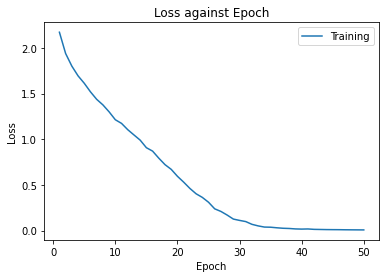

Test Accuracy of the model: 99.99 %
done for k=24; n=256
Epoch: 1 	Training Loss: 2.159412
Epoch: 2 	Training Loss: 1.905633
Epoch: 3 	Training Loss: 1.780615
Epoch: 4 	Training Loss: 1.647163
Epoch: 5 	Training Loss: 1.544619
Epoch: 6 	Training Loss: 1.467964
Epoch: 7 	Training Loss: 1.370589
Epoch: 8 	Training Loss: 1.304125
Epoch: 9 	Training Loss: 1.231197
Epoch: 10 	Training Loss: 1.175231
Epoch: 11 	Training Loss: 1.108241
Epoch: 12 	Training Loss: 1.043318
Epoch: 13 	Training Loss: 0.981892
Epoch: 14 	Training Loss: 0.897597
Epoch: 15 	Training Loss: 0.850513
Epoch: 16 	Training Loss: 0.782220
Epoch: 17 	Training Loss: 0.709488
Epoch: 18 	Training Loss: 0.657978
Epoch: 19 	Training Loss: 0.575127
Epoch: 20 	Training Loss: 0.510581
Epoch: 21 	Training Loss: 0.453301
Epoch: 22 	Training Loss: 0.413562
Epoch: 23 	Training Loss: 0.326916
Epoch: 24 	Training Loss: 0.286037
Epoch: 25 	Training Loss: 0.199079
Epoch: 26 	Training Loss: 0.181139
Epoch: 27 	Training Loss: 0.141602
Epoch: 

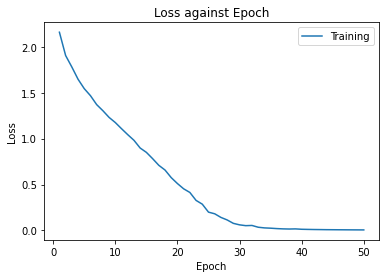

Test Accuracy of the model: 100.00 %
done for k=24; n=512
Epoch: 1 	Training Loss: 2.120078
Epoch: 2 	Training Loss: 1.895614
Epoch: 3 	Training Loss: 1.754965
Epoch: 4 	Training Loss: 1.637542
Epoch: 5 	Training Loss: 1.543618
Epoch: 6 	Training Loss: 1.441691
Epoch: 7 	Training Loss: 1.376788
Epoch: 8 	Training Loss: 1.293339
Epoch: 9 	Training Loss: 1.235580
Epoch: 10 	Training Loss: 1.156916
Epoch: 11 	Training Loss: 1.101451
Epoch: 12 	Training Loss: 1.034135
Epoch: 13 	Training Loss: 0.946471
Epoch: 14 	Training Loss: 0.875336
Epoch: 15 	Training Loss: 0.826233
Epoch: 16 	Training Loss: 0.746361
Epoch: 17 	Training Loss: 0.664384
Epoch: 18 	Training Loss: 0.594758
Epoch: 19 	Training Loss: 0.537196
Epoch: 20 	Training Loss: 0.449720
Epoch: 21 	Training Loss: 0.394676
Epoch: 22 	Training Loss: 0.321581
Epoch: 23 	Training Loss: 0.280260
Epoch: 24 	Training Loss: 0.210432
Epoch: 25 	Training Loss: 0.168349
Epoch: 26 	Training Loss: 0.125776
Epoch: 27 	Training Loss: 0.271456
Epoch:

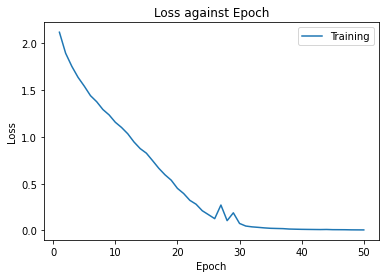

Test Accuracy of the model: 100.00 %
done for k=24; n=1024
Epoch: 1 	Training Loss: 2.148724
Epoch: 2 	Training Loss: 1.926420
Epoch: 3 	Training Loss: 1.788988
Epoch: 4 	Training Loss: 1.652744
Epoch: 5 	Training Loss: 1.571176
Epoch: 6 	Training Loss: 1.474073
Epoch: 7 	Training Loss: 1.405932
Epoch: 8 	Training Loss: 1.325220
Epoch: 9 	Training Loss: 1.238606
Epoch: 10 	Training Loss: 1.188051
Epoch: 11 	Training Loss: 1.117202
Epoch: 12 	Training Loss: 1.037492
Epoch: 13 	Training Loss: 0.958734
Epoch: 14 	Training Loss: 0.891414
Epoch: 15 	Training Loss: 0.834902
Epoch: 16 	Training Loss: 0.728968
Epoch: 17 	Training Loss: 0.667079
Epoch: 18 	Training Loss: 0.578659
Epoch: 19 	Training Loss: 0.493808
Epoch: 20 	Training Loss: 0.450381
Epoch: 21 	Training Loss: 0.370889
Epoch: 22 	Training Loss: 0.291337
Epoch: 23 	Training Loss: 0.274217
Epoch: 24 	Training Loss: 0.169736
Epoch: 25 	Training Loss: 0.184377
Epoch: 26 	Training Loss: 0.139318
Epoch: 27 	Training Loss: 0.080236
Epoch

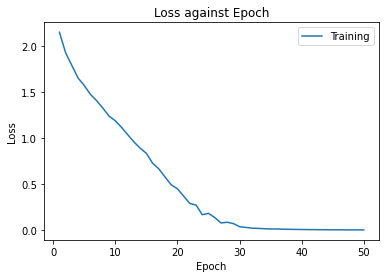

Test Accuracy of the model: 100.00 %
done for k=24; n=2048
Epoch: 1 	Training Loss: 2.150478
Epoch: 2 	Training Loss: 1.911346
Epoch: 3 	Training Loss: 1.741197
Epoch: 4 	Training Loss: 1.613158
Epoch: 5 	Training Loss: 1.527246
Epoch: 6 	Training Loss: 1.458185
Epoch: 7 	Training Loss: 1.353115
Epoch: 8 	Training Loss: 1.287141
Epoch: 9 	Training Loss: 1.218700
Epoch: 10 	Training Loss: 1.155643
Epoch: 11 	Training Loss: 1.085504
Epoch: 12 	Training Loss: 1.036322
Epoch: 13 	Training Loss: 0.971859
Epoch: 14 	Training Loss: 0.909087
Epoch: 15 	Training Loss: 0.846619
Epoch: 16 	Training Loss: 0.780292
Epoch: 17 	Training Loss: 0.747237
Epoch: 18 	Training Loss: 0.657150
Epoch: 19 	Training Loss: 0.614245
Epoch: 20 	Training Loss: 0.576707
Epoch: 21 	Training Loss: 0.485690
Epoch: 22 	Training Loss: 0.467594
Epoch: 23 	Training Loss: 0.381689
Epoch: 24 	Training Loss: 0.348584
Epoch: 25 	Training Loss: 0.283289
Epoch: 26 	Training Loss: 0.252192
Epoch: 27 	Training Loss: 0.197678
Epoch

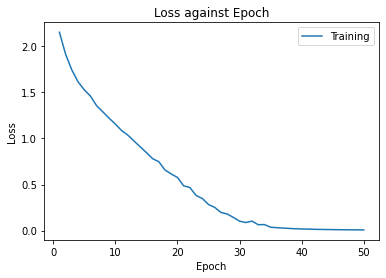

Test Accuracy of the model: 100.00 %
done for k=48; n=128
Epoch: 1 	Training Loss: 2.201125
Epoch: 2 	Training Loss: 1.984824
Epoch: 3 	Training Loss: 1.809025
Epoch: 4 	Training Loss: 1.702822
Epoch: 5 	Training Loss: 1.588074
Epoch: 6 	Training Loss: 1.514432
Epoch: 7 	Training Loss: 1.409012
Epoch: 8 	Training Loss: 1.351952
Epoch: 9 	Training Loss: 1.289706
Epoch: 10 	Training Loss: 1.200267
Epoch: 11 	Training Loss: 1.129131
Epoch: 12 	Training Loss: 1.075133
Epoch: 13 	Training Loss: 1.004870
Epoch: 14 	Training Loss: 0.944395
Epoch: 15 	Training Loss: 0.881716
Epoch: 16 	Training Loss: 0.809704
Epoch: 17 	Training Loss: 0.745795
Epoch: 18 	Training Loss: 0.672309
Epoch: 19 	Training Loss: 0.629340
Epoch: 20 	Training Loss: 0.551069
Epoch: 21 	Training Loss: 0.495410
Epoch: 22 	Training Loss: 0.431891
Epoch: 23 	Training Loss: 0.366901
Epoch: 24 	Training Loss: 0.327788
Epoch: 25 	Training Loss: 0.285126
Epoch: 26 	Training Loss: 0.237813
Epoch: 27 	Training Loss: 0.182033
Epoch:

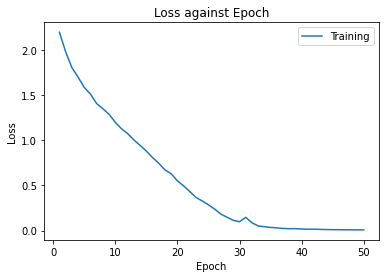

Test Accuracy of the model: 100.00 %
done for k=48; n=256
Epoch: 1 	Training Loss: 2.132854
Epoch: 2 	Training Loss: 1.903102
Epoch: 3 	Training Loss: 1.734908
Epoch: 4 	Training Loss: 1.615260
Epoch: 5 	Training Loss: 1.501582
Epoch: 6 	Training Loss: 1.438264
Epoch: 7 	Training Loss: 1.334898
Epoch: 8 	Training Loss: 1.287689
Epoch: 9 	Training Loss: 1.196833
Epoch: 10 	Training Loss: 1.123471
Epoch: 11 	Training Loss: 1.066236
Epoch: 12 	Training Loss: 0.998600
Epoch: 13 	Training Loss: 0.928441
Epoch: 14 	Training Loss: 0.882248
Epoch: 15 	Training Loss: 0.777652
Epoch: 16 	Training Loss: 0.712357
Epoch: 17 	Training Loss: 0.646479
Epoch: 18 	Training Loss: 0.589548
Epoch: 19 	Training Loss: 0.506034
Epoch: 20 	Training Loss: 0.439534
Epoch: 21 	Training Loss: 0.374464
Epoch: 22 	Training Loss: 0.314203
Epoch: 23 	Training Loss: 0.281451
Epoch: 24 	Training Loss: 0.225486
Epoch: 25 	Training Loss: 0.174320
Epoch: 26 	Training Loss: 0.145941
Epoch: 27 	Training Loss: 0.096403
Epoch:

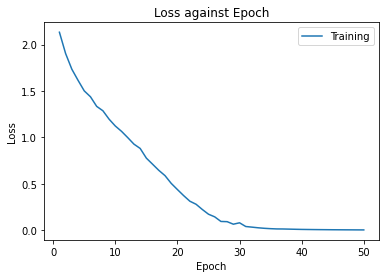

Test Accuracy of the model: 100.00 %
done for k=48; n=512
Epoch: 1 	Training Loss: 2.186511
Epoch: 2 	Training Loss: 1.935400
Epoch: 3 	Training Loss: 1.768960
Epoch: 4 	Training Loss: 1.643156
Epoch: 5 	Training Loss: 1.528797
Epoch: 6 	Training Loss: 1.438370
Epoch: 7 	Training Loss: 1.381574
Epoch: 8 	Training Loss: 1.298752
Epoch: 9 	Training Loss: 1.215719
Epoch: 10 	Training Loss: 1.142194
Epoch: 11 	Training Loss: 1.079154
Epoch: 12 	Training Loss: 1.007404
Epoch: 13 	Training Loss: 0.925206
Epoch: 14 	Training Loss: 0.856346
Epoch: 15 	Training Loss: 0.791671
Epoch: 16 	Training Loss: 0.717072
Epoch: 17 	Training Loss: 0.631142
Epoch: 18 	Training Loss: 0.566951
Epoch: 19 	Training Loss: 0.489851
Epoch: 20 	Training Loss: 0.431606
Epoch: 21 	Training Loss: 0.361032
Epoch: 22 	Training Loss: 0.286678
Epoch: 23 	Training Loss: 0.259894
Epoch: 24 	Training Loss: 0.205075
Epoch: 25 	Training Loss: 0.172330
Epoch: 26 	Training Loss: 0.132683
Epoch: 27 	Training Loss: 0.133696
Epoch:

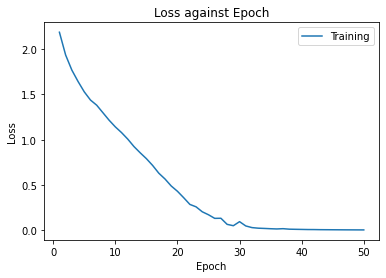

Test Accuracy of the model: 100.00 %
done for k=48; n=1024
Epoch: 1 	Training Loss: 2.115082
Epoch: 2 	Training Loss: 1.884808
Epoch: 3 	Training Loss: 1.740964
Epoch: 4 	Training Loss: 1.618452
Epoch: 5 	Training Loss: 1.510739
Epoch: 6 	Training Loss: 1.419620
Epoch: 7 	Training Loss: 1.340056
Epoch: 8 	Training Loss: 1.279888
Epoch: 9 	Training Loss: 1.200618
Epoch: 10 	Training Loss: 1.120395
Epoch: 11 	Training Loss: 1.061695
Epoch: 12 	Training Loss: 0.993191
Epoch: 13 	Training Loss: 0.899727
Epoch: 14 	Training Loss: 0.835062
Epoch: 15 	Training Loss: 0.766017
Epoch: 16 	Training Loss: 0.675096
Epoch: 17 	Training Loss: 0.605384
Epoch: 18 	Training Loss: 0.559472
Epoch: 19 	Training Loss: 0.446682
Epoch: 20 	Training Loss: 0.404160
Epoch: 21 	Training Loss: 0.337440
Epoch: 22 	Training Loss: 0.264339
Epoch: 23 	Training Loss: 0.214564
Epoch: 24 	Training Loss: 0.194144
Epoch: 25 	Training Loss: 0.140883
Epoch: 26 	Training Loss: 0.097851
Epoch: 27 	Training Loss: 0.087641
Epoch

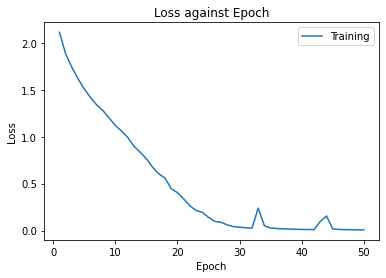

Test Accuracy of the model: 100.00 %
done for k=48; n=2048


In [28]:
#Create, train and test variants of CNN
CNNs={}
accuracy={}
for k in [3,6,12,24,48]:
    CNNs[k]={}
    accuracy[k]={}
    for n in [128, 256, 512, 1024, 2048]:
        CNNs[k][n]=CNN_variant(k, n)
        train(CNNs[k][n], learning_rate=0.1)
        accuracy[k][n]=test(CNNs[k][n])
        print('done for k='+str(k)+'; n='+str(n))

In [29]:
#Print in tabular format for accuracy in testing data
rows=[]
count=0
for n in [128, 256, 512, 1024, 2048]:
    rows.append(['n='+str(n)])
    for k in [3,6,12,24,48]:
        rows[count].append("{:.2f}".format(accuracy[k][n]*100)+'%')
    count += 1
        
print('CNN variant accuracy in testing data')
from tabulate import tabulate
print(tabulate(rows, headers=['Accuracy', 'k=3', 'k=6','k=12','k=24','k=48']))


CNN variant accuracy in testing data
Accuracy    k=3     k=6     k=12     k=24     k=48
----------  ------  ------  -------  -------  -------
n=128       89.55%  99.44%  99.99%   99.99%   100.00%
n=256       99.66%  99.96%  100.00%  99.99%   100.00%
n=512       99.76%  99.47%  99.99%   100.00%  100.00%
n=1024      99.94%  99.94%  100.00%  100.00%  100.00%
n=2048      92.73%  49.36%  100.00%  100.00%  100.00%


# Tuning Learning Rate
The first success of achieving accuracy over 99% is done by increasing learning rate (from 0.005 to 0.1) of the first tried CNN model, as it was observed learning too slowly and the accuracy was too low, and based on my analogy with Newton's Method of converging numerical solutions (where "learning rate" is simply 1). Hence, it must have great impact to the accuracry and performance within a limited number of epochs (50 in our case). As we already achieve 100% accuracy, we will focus more on model simplicity (a.k.a. fewer parameters) by tuning learning rate and won't bother with regularization tuning. Hoping to speed up convergence to improve from 99% accuracy to 100%, we try only higher learning rate.

In [30]:
for k, n in [[3,128],[6,128],[12,128],[3,256],[6,256],[12,256],[3,512],[6,512],[3,1024]]:
    CNNs[k][n]=CNN_variant(k, n)
    train(CNNs[k][n], learning_rate=0.2, visible=False)
    print('k='+str(k)+', n='+str(n)+' -- ', end='')
    test(CNNs[k][n])

k=3, n=128 -- Test Accuracy of the model: 94.14 %
k=6, n=128 -- Test Accuracy of the model: 100.00 %
k=12, n=128 -- Test Accuracy of the model: 100.00 %
k=3, n=256 -- Test Accuracy of the model: 99.71 %
k=6, n=256 -- Test Accuracy of the model: 99.92 %
k=12, n=256 -- Test Accuracy of the model: 100.00 %
k=3, n=512 -- Test Accuracy of the model: 100.00 %
k=6, n=512 -- Test Accuracy of the model: 99.95 %
k=3, n=1024 -- Test Accuracy of the model: 99.96 %


# Conclusion

If we approximate the number of parameters by ignoring bias term, we can have the following formula:
no. of parameters ~= 9k + 256kn +10n

By minimizing the formula, we have (k=3, n=128)  or (k=6, n=128) as the simplest 2 models.

Before we conclude, let's test the robustness against randomness, and use a training function that enables us to see validation loss as well.


Epoch: 1 	Training Loss: 2.223609 	Validation Loss: 4.016062
Epoch: 2 	Training Loss: 2.233946 	Validation Loss: 2.134457
Epoch: 3 	Training Loss: 2.079443 	Validation Loss: 1.942284
Epoch: 4 	Training Loss: 1.928195 	Validation Loss: 1.908850
Epoch: 5 	Training Loss: 1.830276 	Validation Loss: 1.775204
Epoch: 6 	Training Loss: 1.765532 	Validation Loss: 1.746595
Epoch: 7 	Training Loss: 1.690132 	Validation Loss: 1.621751
Epoch: 8 	Training Loss: 1.618482 	Validation Loss: 1.555154
Epoch: 9 	Training Loss: 1.590417 	Validation Loss: 1.494252
Epoch: 10 	Training Loss: 1.532045 	Validation Loss: 1.420731
Epoch: 11 	Training Loss: 1.489228 	Validation Loss: 1.433158
Epoch: 12 	Training Loss: 1.464131 	Validation Loss: 1.419064
Epoch: 13 	Training Loss: 1.404712 	Validation Loss: 1.320168
Epoch: 14 	Training Loss: 1.391835 	Validation Loss: 1.392336
Epoch: 15 	Training Loss: 1.339261 	Validation Loss: 1.340613
Epoch: 16 	Training Loss: 1.303601 	Validation Loss: 1.251062
Epoch: 17 	Traini

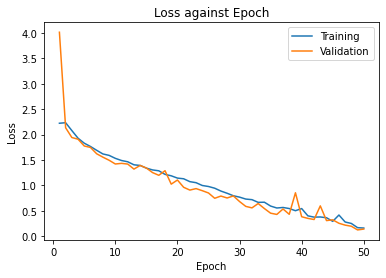

Test Accuracy of the model: 95.78 %


0.9578

In [31]:
seed=1
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)
rng = np.random.default_rng(seed=seed)
CNNs[3][128]=CNN_variant(3, 128)
train_val(CNNs[3][128], learning_rate=0.2)
test(CNNs[3][128])

Epoch: 1 	Training Loss: 2.224014 	Validation Loss: 2.066893
Epoch: 2 	Training Loss: 2.083758 	Validation Loss: 1.910464
Epoch: 3 	Training Loss: 1.901599 	Validation Loss: 1.790663
Epoch: 4 	Training Loss: 1.749762 	Validation Loss: 1.617053
Epoch: 5 	Training Loss: 1.654808 	Validation Loss: 1.504030
Epoch: 6 	Training Loss: 1.562195 	Validation Loss: 1.393200
Epoch: 7 	Training Loss: 1.485305 	Validation Loss: 1.511925
Epoch: 8 	Training Loss: 1.426904 	Validation Loss: 1.320374
Epoch: 9 	Training Loss: 1.355711 	Validation Loss: 1.239357
Epoch: 10 	Training Loss: 1.279244 	Validation Loss: 1.157532
Epoch: 11 	Training Loss: 1.220070 	Validation Loss: 1.161795
Epoch: 12 	Training Loss: 1.178390 	Validation Loss: 1.053249
Epoch: 13 	Training Loss: 1.109151 	Validation Loss: 0.978354
Epoch: 14 	Training Loss: 1.036765 	Validation Loss: 0.986818
Epoch: 15 	Training Loss: 0.982462 	Validation Loss: 0.845916
Epoch: 16 	Training Loss: 0.916351 	Validation Loss: 0.732635
Epoch: 17 	Traini

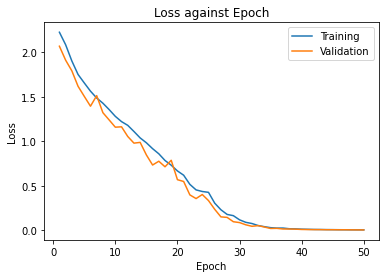

Test Accuracy of the model: 100.00 %


1.0

In [32]:
seed=1
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)
rng = np.random.default_rng(seed=seed)
CNNs[6][128]=CNN_variant(6, 128)
train_val(CNNs[6][128], learning_rate=0.2)
test(CNNs[6][128])

Epoch: 1 	Training Loss: 2.206621 	Validation Loss: 2.038084
Epoch: 2 	Training Loss: 2.107955 	Validation Loss: 1.988956
Epoch: 3 	Training Loss: 2.008187 	Validation Loss: 2.186863
Epoch: 4 	Training Loss: 1.956120 	Validation Loss: 1.939119
Epoch: 5 	Training Loss: 1.834907 	Validation Loss: 1.757576
Epoch: 6 	Training Loss: 1.745814 	Validation Loss: 1.750170
Epoch: 7 	Training Loss: 1.645598 	Validation Loss: 1.495588
Epoch: 8 	Training Loss: 1.574355 	Validation Loss: 1.434736
Epoch: 9 	Training Loss: 1.505632 	Validation Loss: 1.478475
Epoch: 10 	Training Loss: 1.459338 	Validation Loss: 1.367053
Epoch: 11 	Training Loss: 1.433881 	Validation Loss: 1.313752
Epoch: 12 	Training Loss: 1.377731 	Validation Loss: 1.243402
Epoch: 13 	Training Loss: 1.310787 	Validation Loss: 1.197561
Epoch: 14 	Training Loss: 1.239947 	Validation Loss: 1.170406
Epoch: 15 	Training Loss: 1.218605 	Validation Loss: 1.088853
Epoch: 16 	Training Loss: 1.169375 	Validation Loss: 1.097309
Epoch: 17 	Traini

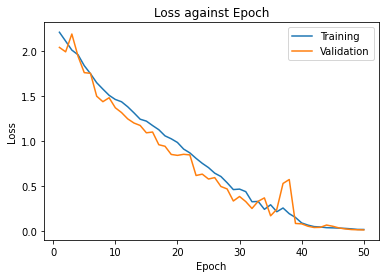

Test Accuracy of the model: 99.91 %


0.9991

In [33]:
seed=2
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)
rng = np.random.default_rng(seed=seed)
CNNs[6][128]=CNN_variant(6, 128)
train_val(CNNs[6][128], learning_rate=0.2)
test(CNNs[6][128])

So, (k=3, n=128) can be ruled out.

Although (k=6, n=128) doesn't get 100% accuracy in all random states above, we can't guarantee 100% accuracy of other models in all random states either. And 99.91% still looks very good. And there is a possibilty that it may converge further given more epochs.

So among above trials, the simplest model that has got 99.9%-100% accuracy is (k=6, n=128), i.e.
1 convolutional layer (6 channels, kernels size 3, stride 1, padding 1, with MaxPool(2,2) then RELU), followed by 1 hidden fully connected layer (128 nodes, RELU) and 1 output layer (10 classes), at learning rate = 0.2 using Pytorch SGD optimizer with batch size 100, 50 epochs and cross-entropy loss function.

Disclaimer: we cannot guarantee it has 99.9%-100% accuracy in every random state, though we have tested multiple random states for initialization of weights and training. But at least we have proved that there exists some sets of weights for such simple CNN model to acheive extremely high (if not prefect) accuracy.

Note: learning rate of 0.2 may cause some other variant models to deteriorate sharply in accuracy in certain random states. This may also imply possibly there are local optima for similar variant models in this application.

Let's save the final model.

In [34]:
torch.save(CNNs[6][128].state_dict(), './cifar_CNN_final.pth')

### Others
For the chosen model, the validation loss curve is consistently slightly lower than training loss for most of the time, possibly due to combination of two reasons:
1) the model learns so well that it doesn't over-fit and
2) the validation loss is calculated in model.eval, after the model.train mode, so it always uses parameters more recently updated (one mini-batch ahead of those calculating training loss).

### Reference
https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

https://cs231n.github.io/convolutional-networks/

https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module